## Hand Recognition Training Notebook
 

In [48]:
try:
    import sklearn
except ImportError:
    !pip install scikit-learn
    import sklearn


In [49]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Model Path Specification

In [50]:
dataset = 'model/keypoint_classifier/keypoint_store.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [82]:
number_classes = 6
import numpy as np

# Define the expected length of each row (including the class index)
expected_length = 44  # Based on the sample provided

def check_row_validity(row, expected_length, num_classes=6):
    # Convert the row to a list of floats
    try:
        row_data = np.array(row.split(','), dtype='float')
    except ValueError as e:
        return False, f"Error parsing row: {str(e)}"

    # Check if the row length matches the expected length
    if len(row_data) != expected_length:
        return False, f"Invalid row length: {len(row_data)} (expected {expected_length})"
    
    # Check if the first value (class index) is within the valid range [0, num_classes-1]
    class_index = row_data[0]
    if not (0 <= class_index < num_classes):
        return False, f"Invalid class index: {class_index}"

    # Check if all other values are finite numbers (not NaN or Inf)
    if not np.isfinite(row_data).all():
        return False, "Row contains non-finite values (NaN or Inf)"
    
    # If all checks pass, the row is valid
    return True, ""

# Process the dataset
valid_rows = []
invalid_rows = []

with open('model/keypoint_classifier/keypoint_store.csv', 'r') as f:
    for i, line in enumerate(f, start=1):
        is_valid, reason = check_row_validity(line.strip(), expected_length)
        if is_valid:
            valid_rows.append(line.strip())
        else:
            invalid_rows.append((i, line.strip(), reason))

# Output the results
print(f"Total valid rows: {len(valid_rows)}")
print(f"Total invalid rows: {len(invalid_rows)}\n")

if invalid_rows:
    print("Invalid rows details:")
    for row in invalid_rows:
        print(f"Line {row[0]}: {row[1]} - {row[2]}")


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Set number of classes

In [51]:
NUM_CLASSES = 6

# Dataset reading

In [52]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [53]:
X_dataset

array([[ 0.        ,  0.        ,  0.2007874 , ..., -0.68503934,
        -0.22047244, -0.78740156],
       [ 0.        ,  0.        ,  0.20634921, ..., -0.6904762 ,
        -0.21031746, -0.7936508 ],
       [ 0.        ,  0.        ,  0.20238096, ..., -0.68650794,
        -0.21428572, -0.78968257],
       ...,
       [ 0.        ,  0.        , -0.17427386, ..., -0.71784234,
         0.24481328, -0.8174274 ],
       [ 0.        ,  0.        ,  0.2457627 , ..., -0.7966102 ,
        -0.26271185, -0.8135593 ],
       [ 0.        ,  0.        ,  0.24647887, ..., -0.6971831 ,
        -0.21830986, -0.59859157]], dtype=float32)

In [54]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [55]:
y_dataset


array([0, 0, 0, ..., 0, 2, 2])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [57]:
print(np.unique(y_train))

[0 1 2 3]


In [58]:
print(np.unique(y_test))

[0 1 2 3]


In [59]:
import numpy as np

with open(dataset, 'r') as f:
    for i, line in enumerate(f):
        values = line.strip().split(',')
        try:
            # Attempt to convert the first column to an integer
            label = int(float(values[0]))
            # Check if the label is valid (within your expected range)
            if label < 0 or label >= NUM_CLASSES:
                print(f"Invalid label {label} found on line {i+1}")
        except ValueError:
            print(f"Corrupt data found on line {i+1}: {line}")


# Model building

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [61]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,136 (4.44 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [63]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [64]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 21s 753ms/step - accuracy: 0.2188 - loss: 1.7691
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2531 - loss: 1.7596 - val_accuracy: 0.3710 - val_loss: 1.5420
Epoch 2/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3438 - loss: 1.5453
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3337 - loss: 1.5267 - val_accuracy: 0.4079 - val_loss: 1.3451
Epoch 3/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3203 - loss: 1.3995
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3761 - loss: 1.3687 - val_accuracy: 0.5324 - val_loss: 1.2276
Epoch 4/1000
 1/29 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4766 - loss: 1.2316
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ker

In [65]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9616 - loss: 0.1925 


In [66]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [67]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[1.2574880e-01 8.4485507e-01 1.9800145e-02 9.5953904e-03 1.8280855e-07
 3.8144819e-07]
1


# Confusion matrix

In [68]:
!pip install pandas


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Papa Yaw\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [69]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Papa Yaw\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


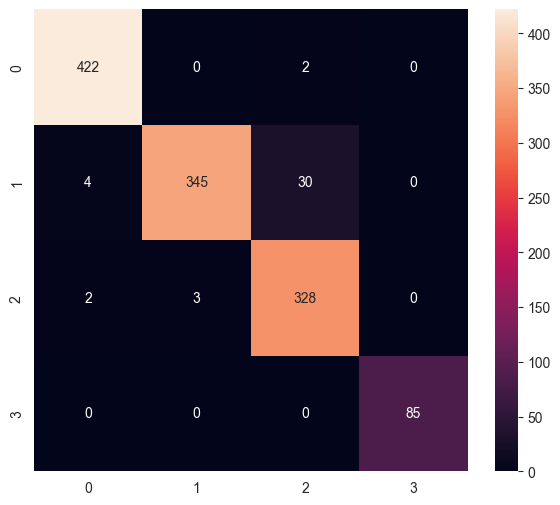

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       424
           1       0.99      0.91      0.95       379
           2       0.91      0.98      0.95       333
           3       1.00      1.00      1.00        85

    accuracy                           0.97      1221
   macro avg       0.97      0.97      0.97      1221
weighted avg       0.97      0.97      0.97      1221



In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [71]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [72]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\PAPAYA~1\AppData\Local\Temp\tmpnr7a0zhi\assets


INFO:tensorflow:Assets written to: C:\Users\PAPAYA~1\AppData\Local\Temp\tmpnr7a0zhi\assets


Saved artifact at 'C:\Users\PAPAYA~1\AppData\Local\Temp\tmpnr7a0zhi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2466548429456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2466548430992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2466548430608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2466548419088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2466548418704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2466548431760: TensorSpec(shape=(), dtype=tf.resource, name=None)


6628

# Inference test

In [73]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [74]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [75]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [76]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.2574887e-01 8.4485507e-01 1.9800160e-02 9.5953988e-03 1.8280872e-07
 3.8144819e-07]
1
